# Explore TM-Align Results

**TM-Align**

* Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
* Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
* The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)

**RMSD**

* We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. (https://www.mdpi.com/1420-3049/23/5/1038/htm)

# TM-Align Development

In [5]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from multiprocessing import Pool
import random
import pandas as pd

In [6]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(pairs_and_labels, chunk=0):
    '''
    Accepts an n x 3 (query protein, target protein and cluster label) or n x 2 array (query protein and target protein).
    Returns an n x 8 array with original inputs and TM-Align stats for each pair of proteins in the input array. Also writes
    results to pairs_tmalign_rmsd.parquet.
    
    NOTE: The parquet writing is broken at the moment due to multithreading, but the return results is 100% correct, so just
    write your results to file outside this function.
    '''
    result = []
    names = ['query_protein', 'query_protein_length', 'target_protein',
             'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']
    for pair in pairs_and_labels:
        if pair[0] != pair[1]:
            cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
            tmalign_report = os.popen(cmd).readlines()
            result.append(process_report(pair[0], pair[1], tmalign_report))
            if pairs_and_labels.shape[1] > 2:
                result[-1].append(pair[2])
    if pairs_and_labels.shape[1] > 2:
        names.append('cluster')
    chunk = random.randint(0, 100000)
    table = pa.Table.from_pandas(pd.DataFrame(result, columns=names))
    pq.write_table(table, f'tmp/pairs_tmalign_rmsd_{str(chunk)}.parquet')
    return result

In [ ]:
# test data for functions

combinations = np.array([['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']])
print(tmalign(combinations))

In [7]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])

        
#download_file('samples/all_protein_combos_per_cluster.parquet')
#pd.read_parquet('all_protein_combos_per_cluster.parquet').head()

In [12]:
combos = pd.read_parquet('all_protein_combos_per_cluster.parquet')
combos.query_protein = 'AF-' + combos.query_protein.astype(str) + '-F1-model_v1'
combos.target_protein = 'AF-' + combos.target_protein.astype(str) + '-F1-model_v1'
test_combos = combos[['query_protein', 'target_protein', 'cluster']].values

In [ ]:
# SINGLE THREAD (SLOWER)

start = time.time()
answer = tmalign(test_combos)
print(f"took {int(time.time() - start)} seconds")
print(f'Sent {len(test_combos)} records and got back {len(answer)}.')
pd.read_parquet('pairs_tmalign_rmsd_0.parquet').sample(10)

In [ ]:
# OPTIMIZED OVER DEEPFOLD (FASTEST)

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[start::int(size / num_threads)+1] for start in range(int(size / num_threads)+1)]))
    
print(f"took {int(time.time() - start)} seconds")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

table = pa.Table.from_pandas(res)
pq.write_table(table, f'pairs_tmalign_rmsd_merged.parquet')

# TM-Align Production Code

* model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**

In [77]:
# Get the experiment data

# DeepFold + DBSCAN
home = '/home/jupyter/pss/'
file = 'model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet'

download_file(file)

model = pd.read_parquet(home + file.split('/')[-1])
model.query_protein = 'AF-' + model.query_protein.astype(str) + '-F1-model_v1'
model.target_protein = 'AF-' + model.target_protein.astype(str) + '-F1-model_v1'
print(len(model))
model.head()

174584


,query_protein,target_protein,cluster
1,AF-O96009-F1-model_v1,AF-P00797-F1-model_v1,0
2,AF-O96009-F1-model_v1,AF-P07339-F1-model_v1,0
3,AF-O96009-F1-model_v1,AF-P0DJD7-F1-model_v1,0
4,AF-O96009-F1-model_v1,AF-P0DJD8-F1-model_v1,0
5,AF-O96009-F1-model_v1,AF-P0DJD9-F1-model_v1,0


In [78]:
# First get all the tmaligm stats we already computed

batch_stats = pd.read_parquet('pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

315410


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [79]:
# If we already have stats for the pair, save it; run tmalign on the remainder

# First join to batch stats
batch_stats.set_index(['query_protein', 'target_protein'], inplace=True)
model.set_index(['query_protein', 'target_protein'], inplace=True)
model_stats = model.join(batch_stats, on=['query_protein', 'target_protein'], how='left')

In [39]:
# Only focus on novel pairs we've never seen to date; also find clusters with more than 200 pairs
test_combos = model_stats[model_stats.rmsd.isna()].reset_index()
x = test_combos.groupby(['cluster']).count().reset_index()
big_clusters = x[x.query_protein > 200].cluster.values
big_clusters

array([ -1,  64, 189, 209, 283, 287, 342, 364, 399, 400, 424, 432, 436,
       445, 477, 479, 486, 511, 514, 519, 521, 550, 557, 564, 595, 600,
       605])

In [40]:
# Downsample big clusters (> 200 pairs) to 25%
big_cluster_samples = pd.DataFrame(None, columns=x.columns)

for cluster in big_clusters:
    sliced = test_combos[test_combos.cluster == cluster]
    big_cluster_samples = big_cluster_samples.append(sliced.sample(int(len(sliced) * 0.25)))

big_cluster_samples

,cluster,query_protein,target_protein,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
4707,-1,AF-Q5VVX9-F1-model_v1,AF-Q8N9N8-F1-model_v1,NaN,NaN,NaN,NaN,NaN
4099,-1,AF-P21917-F1-model_v1,AF-Q86UP6-F1-model_v1,NaN,NaN,NaN,NaN,NaN
7489,-1,AF-Q8NCJ5-F1-model_v1,AF-O43325-F1-model_v1,NaN,NaN,NaN,NaN,NaN
7038,-1,AF-O94811-F1-model_v1,AF-Q13263-F1-model_v1,NaN,NaN,NaN,NaN,NaN
901,-1,AF-P10074-F1-model_v1,AF-Q9UBB5-F1-model_v1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
58331,605,AF-Q9NS61-F1-model_v1,AF-Q8N9F0-F1-model_v1,NaN,NaN,NaN,NaN,NaN
58503,605,AF-A6NML5-F1-model_v1,AF-Q96HA1-F1-model_v1,NaN,NaN,NaN,NaN,NaN
58308,605,AF-Q53S33-F1-model_v1,AF-Q16609-F1-model_v1,NaN,NaN,NaN,NaN,NaN
57860,605,AF-O75521-F1-model_v1,AF-Q16609-F1-model_v1,NaN,NaN,NaN,NaN,NaN


In [41]:
# Recombine small clusters with big cluster samples
test_combos = test_combos[~test_combos.cluster.isin(big_clusters)].append(big_cluster_samples)

In [42]:
# generate array for tmalign
test_combos = test_combos.values
len(test_combos)

15140

In [43]:
# remove pairs with known giant protein
known_giant_proteins = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/merged_pdbs/')]
zmp = []
for pair in test_combos:
    if pair[0] in known_giant_proteins or pair[1] in known_giant_proteins:
        continue
    else:
        zmp.append(pair)
test_combos = np.array(zmp)
len(test_combos)

14338

In [44]:
# run tmalign and save chunked results to parquet files

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
step = 250
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[i*step:(i+1)*step] for i in range(int(size / step + 1))]))
    
print(f"Took {int((time.time() - start) / 60)} minutes.")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

Took 31 minutes.
Sent 14338 records and got back 14338.


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
12591,AF-Q9Y3P4-F1-model_v1,386,AF-P16260-F1-model_v1,332,142,6.20,0.23447,432
655,AF-P49326-F1-model_v1,533,AF-Q9BS16-F1-model_v1,269,97,6.73,0.11923,486
10979,AF-P10745-F1-model_v1,1247,AF-A6QL63-F1-model_v1,1104,425,9.87,0.21447,342
4337,AF-P01375-F1-model_v1,233,AF-Q8IW75-F1-model_v1,414,107,5.81,0.26867,399
8789,AF-O95922-F1-model_v1,423,AF-Q8TB33-F1-model_v1,94,76,4.41,0.14175,486
2413,AF-Q9UJY5-F1-model_v1,639,AF-Q5SVZ6-F1-model_v1,1142,250,7.72,0.24875,436
2848,AF-Q6PJT7-F1-model_v1,736,AF-Q9BQ95-F1-model_v1,431,115,6.41,0.11488,550
5757,AF-Q8NGC6-F1-model_v1,315,AF-O94777-F1-model_v1,84,68,3.44,0.18051,486
9150,AF-P55285-F1-model_v1,790,AF-P63010-F1-model_v1,937,221,8.33,0.17850,550
6029,AF-Q15929-F1-model_v1,161,AF-P0DN24-F1-model_v1,101,50,4.98,0.18608,521


In [80]:
model_stats = model_stats.reset_index()

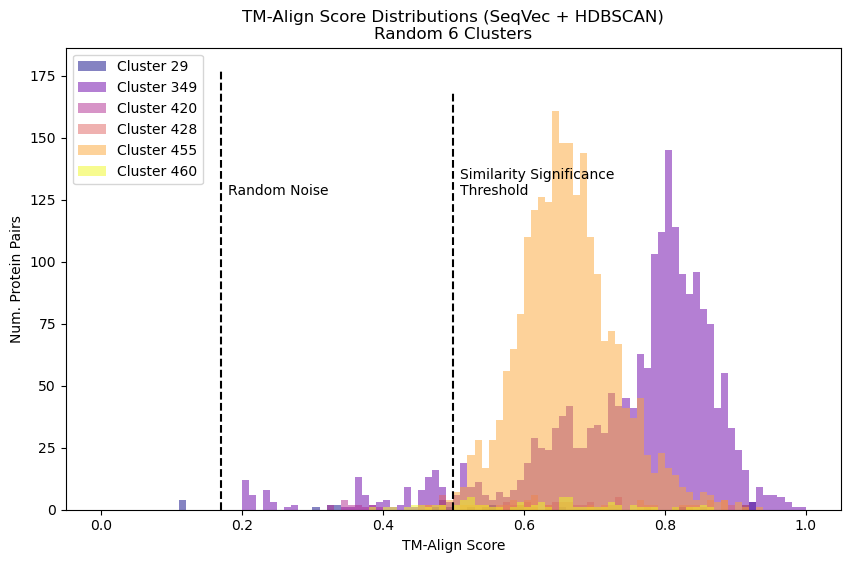

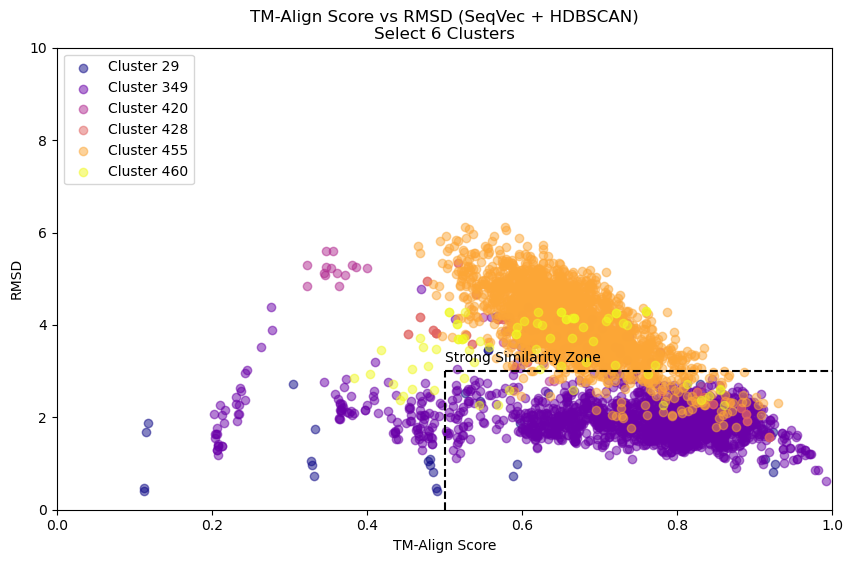

In [84]:
from utils import model_and_evaluate_cluster as ev

cmap = 'plasma'
name = "SeqVec + HDBSCAN"

plot_1_clusters = ev.tmalign_hist(model_stats, version='random', num_results=6, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(model_stats[model_stats.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)